In [9]:
import numpy as np
import pandas as pd
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from omegaconf import OmegaConf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from lightning.pytorch.callbacks import ModelCheckpoint, Callback
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from main import ClimateEmulationDataModule, ClimateEmulationModule
from _climate_kaggle_metric import score as kaggle_score

from src.models import SimpleCNN
from src.utils import convert_predictions_to_kaggle_format

## Functions

### RNN Model

In [11]:
class ClimateRNNNet(nn.Module):
    def __init__(self, in_channels=5, conv_channels=64, rnn_hidden=64, out_channels=2,
                 dropout_prob=0.2, rnn_layers=2):
        super(ClimateRNNNet, self).__init__()

        # Deep CNN encoder for richer spatial features
        self.encoder = nn.Sequential(
            nn.Conv2d(1, conv_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_channels),
            nn.ReLU(),
            nn.Conv2d(conv_channels, conv_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_channels),
            nn.ReLU(),
            nn.Conv2d(conv_channels, conv_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(conv_channels),
            nn.ReLU()
        )

        self.rnn_hidden = rnn_hidden
        self.rnn_layers = rnn_layers

        self.rnn = nn.LSTM(
            input_size=conv_channels,
            hidden_size=rnn_hidden,
            num_layers=rnn_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        self.dropout = nn.Dropout(dropout_prob)

        self.proj = nn.Sequential(
            nn.Linear(rnn_hidden, conv_channels),
            nn.BatchNorm1d(conv_channels),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(conv_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob),
            nn.Conv2d(64, out_channels, kernel_size=1)
        )

    def forward(self, x):
        B, C, H, W = x.shape

        encoded = []
        for t in range(C):
            xt = x[:, t:t+1, :, :]
            feat = self.encoder(xt)
            encoded.append(feat)

        x_seq = torch.stack(encoded, dim=1)  # [B, T, conv_channels, H, W]
        x_seq = x_seq.permute(0, 3, 4, 1, 2)  # [B, H, W, T, conv_channels]
        x_seq = x_seq.reshape(B * H * W, C, -1)  # [B*H*W, T, conv_channels]

        h0 = torch.zeros(self.rnn_layers, x_seq.size(0), self.rnn_hidden, device=x.device)
        c0 = torch.zeros(self.rnn_layers, x_seq.size(0), self.rnn_hidden, device=x.device)

        rnn_out, _ = self.rnn(x_seq, (h0, c0))
        final = rnn_out[:, -1, :]
        final = self.dropout(final)

        out = self.proj(final)
        out = out.view(B, H, W, -1).permute(0, 3, 1, 2)

        return self.decoder(out)


### Training Callback Module

In [12]:
class TrainingMetrics(Callback):
    def __init__(self):
        self.train_epoch_losses = []
        self.val_epoch_losses = []

        self._train_losses = []
        self._val_losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        self._train_losses.append(loss.item())

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        loss = outputs['loss'] if isinstance(outputs, dict) else outputs
        self._val_losses.append(loss.item())

    def on_train_epoch_end(self, trainer, pl_module):
        if self._train_losses:
            avg = sum(self._train_losses) / len(self._train_losses)
            self.train_epoch_losses.append(avg)
            self._train_losses.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        if self._val_losses:
            avg = sum(self._val_losses) / len(self._val_losses)
            self.val_epoch_losses.append(avg)
            self._val_losses.clear()


### Plotting functions

In [22]:
def plot_batch_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))

    plt.plot(train_losses, label="Train Loss (per batch)", linewidth=0.8, alpha=0.8)
    plt.plot(val_losses, label="Validation Loss (per batch)", linewidth=0.8, alpha=0.8)

    plt.xlabel("Batch (time)")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_epoch_losses(train_epoch_losses, val_epoch_losses):
    n = len(train_epoch_losses)
    epochs = range(1, n + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_epoch_losses, label='Train Loss (per epoch)', marker='o')
    plt.plot(epochs, val_epoch_losses, label='Validation Loss (per epoch)', marker='s')

    min_val_loss = min(val_epoch_losses)
    min_epoch = val_epoch_losses.index(min_val_loss) + 1

    plt.annotate(
        f"Min Val Loss: {min_val_loss:.4f}",
        xy=(min_epoch, min_val_loss),
        xytext=(min_epoch - 1, min_val_loss + 0.1),
        arrowprops=dict(arrowstyle="->", color='black'),
        fontsize=10,
        color='black'
    )

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.xticks(range(0, n + 1, 5))

    plt.tight_layout()
    plt.show()

def plot_top_mse_grid_points(y_pred_np, y_true_np, lat_coords, lon_coords, var_names, top_k=3):
    T, C, H, W = y_true_np.shape
    squared_error = (y_pred_np - y_true_np) ** 2

    top_coords = []

    for c in range(C):
        var = var_names[int(c)]
        var_error = squared_error[:, c, :, :]
        flat_error = var_error.reshape(-1)
        top_k_idx = np.argpartition(flat_error, -top_k)[-top_k:]
        top_k_idx = top_k_idx[np.argsort(flat_error[top_k_idx])[::-1]]

        for idx in top_k_idx:
            t, h, w = np.unravel_index(idx, (T, H, W))
            top_coords.append({
                "var": var,
                "t": int(t),
                "h": int(h),
                "w": int(w),
                "mse": var_error[t, h, w].item()
            })

    plt.figure(figsize=(10, 6))
    plt.imshow(np.zeros((H, W)), cmap='Greys', alpha=0.1)

    color_map = {var: color for var, color in zip(var_names, ['red', 'blue', 'green', 'orange'])}

    for entry in top_coords:
        plt.scatter(entry["w"], entry["h"], color=color_map[entry["var"]],
                    s=100, edgecolors='black')

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label=var,
               markerfacecolor=color_map[var], markersize=10, markeredgecolor='black')
        for var in var_names
    ]
    plt.legend(handles=legend_elements)
    plt.title(f"Top {top_k} Highest MSE Grid Locations per Output Variable")
    plt.xlabel("Longitude Index (W)")
    plt.ylabel("Latitude Index (H)")
    plt.xlim(0, W - 1)
    plt.ylim(H - 1, 0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Training

In [14]:
data_path = 'data/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr'

In [15]:
config = OmegaConf.create({
    "data": {
        "path": data_path,
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        # "input_vars": ["CO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "target_member_id": 0,
        "batch_size": 32,
        "num_workers": 39,
        
    }
})

In [16]:
data_module = ClimateEmulationDataModule(**config.data)
data_module.setup()

In [17]:
in_channels = len(config.data['input_vars'])
out_channels = len(config.data['output_vars'])

model = ClimateRNNNet(in_channels=in_channels, out_channels=out_channels)

lightning_module=ClimateEmulationModule(
    model = model,
    learning_rate = 5e-4
)

In [24]:
logger = TrainingMetrics()

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    callbacks=[logger]    
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [25]:
trainer.fit(lightning_module, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | model     | ClimateRNNNet | 182 K  | train
1 | criterion | MSELoss       | 0      | train
----------------------------------------------------
182 K     Trainable params
0         Non-trainable params
182 K     Total params
0.732     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


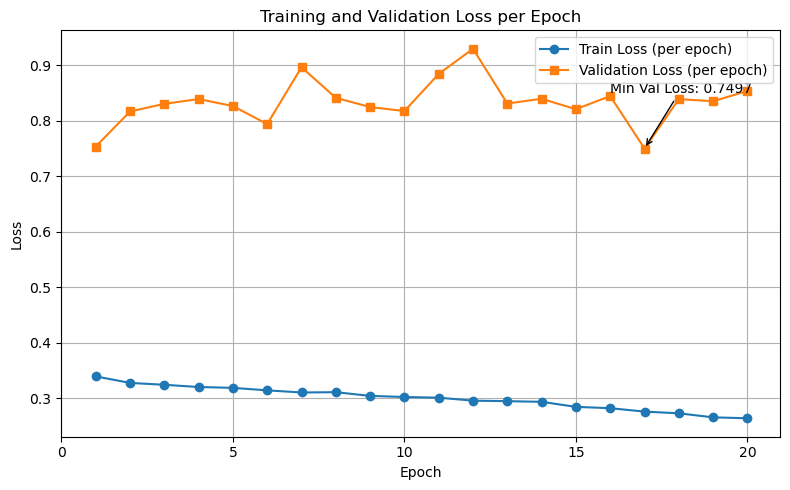

In [26]:
train_losses = logger.train_epoch_losses
val_losses = logger.val_epoch_losses
min_len = min(len(train_losses), len(val_losses))

plot_epoch_losses(train_losses[:min_len], val_losses[:min_len])

In [ ]:
trainer.test(lightning_module, data_module)

## Produce Test Predictions

In [ ]:
model.eval()
all_preds = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for x, y_true in data_module.test_dataloader():
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x.to(device)).squeeze(0)
    all_preds.append(y_pred.cpu().numpy())

y_pred_np = np.concatenate(all_preds, axis=0)
y_pred_output = data_module.normalizer.inverse_transform_output(y_pred_np)

lat_coords, lon_coords = data_module.get_coords()
time_coords = np.arange(y_pred_np.shape[0])
var_names = config.data['output_vars']

In [ ]:
submission_df = convert_predictions_to_kaggle_format(
    y_pred_output, time_coords, lat_coords, lon_coords, var_names
)

In [ ]:
print(submission_df.shape)

In [ ]:
submission_df.to_csv("submission.csv", index=False)

## Exploration

In [ ]:
model.eval()
all_preds = []
all_trues = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for x, y_true in data_module.train_dataloader():
    x = x.to(device)
    with torch.no_grad():
        y_pred = model(x.to(device)).squeeze(0)
    all_preds.append(y_pred.cpu().numpy())
    all_trues.append(y_true.cpu().numpy())
    
y_pred_np = np.concatenate(all_preds, axis=0)
y_true_np = np.concatenate(all_trues, axis=0)

lat_coords, lon_coords = data_module.get_coords()
var_names = config.data['output_vars']

In [ ]:
T, C, H, W = squared_error.shape
top_k = 3

top_coords = []

for c in range(C):
    var = var_names[int(c)]
    var_error = squared_error[:, c, :, :]

    flat_error = var_error.reshape(-1)
    top_k_idx = np.argpartition(flat_error, -top_k)[-top_k:]
    top_k_idx = top_k_idx[np.argsort(flat_error[top_k_idx])[::-1]]

    for idx in top_k_idx:
        t, h, w = np.unravel_index(idx, (T, H, W))
        top_coords.append({
            "time": int(t),
            "h": int(h),
            "w": int(w),
            "var": var,
            "mse": var_error[t, h, w].item()
        })
top_coords_df = pd.DataFrame(top_coords)

In [ ]:
plot_top_mse_grid_points(
    y_pred_np=y_pred_np,
    y_true_np=y_true_np,
    lat_coords=lat_coords,
    lon_coords=lon_coords,
    var_names=config.data['output_vars'],
    top_k=3
)